 # kNN a křížová validace

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn import metrics, datasets
from sklearn.model_selection import ParameterGrid, train_test_split, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_seed = 12247112

## Metoda kNN (k nejbližších sousedů)

<center><img src="img/knn.svg" width="40%"></center>
<center>(zdroj: https://commons.wikimedia.org/wiki/File:KnnClassification.svg, autor: Antti Ajanki)</center>

### Hyperparametry:
- `n_neighbors`: počet nejbližších sousedů (defaultně `5`)
- `weights`: způsob výpočtu vah používaných při predikci (defaultně `'uniform'`)
- `metric`: použitá vzdálenost (defaultně `'minkowski'`)
- `p`: stupeň Minkowského vzdálenosti (defaultně `2`, tedy euklidovská)

## Použití kNN na Iris datasetu

Načteme si Iris data pomocí modulu `sklearn.datasets`. Ta standardně pro každý záznam obsahují 4 různá měření v centimetrech a dělí se na 3 třídy. Řešíme tedy klasifikační problém. Práci si ale trochu ztížíme a první příznak převedeme na milimetry.

In [23]:
iris = datasets.load_iris()
X = iris.data

print('Data sample:')
display(X[:5,:])

Data sample:


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [24]:
# Převedeme první příznak z centimetrů na milimetry
X[:, 0] *= 10
y = iris.target

print('Shape: ', X.shape, '\n')
print('Data sample:')
display(X[:5,:])

Shape:  (150, 4) 

Data sample:


array([[51. ,  3.5,  1.4,  0.2],
       [49. ,  3. ,  1.4,  0.2],
       [47. ,  3.2,  1.3,  0.2],
       [46. ,  3.1,  1.5,  0.2],
       [50. ,  3.6,  1.4,  0.2]])

Pomocí již dobře známé funkce `train_test_split` rozdělíme data na trénovací a testovací v poměru 6:4:

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=random_seed)

Na trénovacích datech si spočítáme minimum, maximum a průměr. Dle očekávání jsou hodnoty prvního příznaku značně vyšší než ostatní.

In [11]:
d = stats.describe(Xtrain)
print('Min: ', d.minmax[0])
print('Max: ', d.minmax[1])
print('Mean:', d.mean)

Min:  [45.   2.   1.2  0.1]
Max:  [79.   4.2  6.9  2.4]
Mean: [59.67777778  3.03222222  3.98777778  1.28333333]


Data si můžeme vizualizovat pomocí scatter plotu. Vidíme, že dvě ze tříd se mírně překrývají. To by ale pro kNN klasifikátor (např. oproti lineární separaci) neměl být problém.

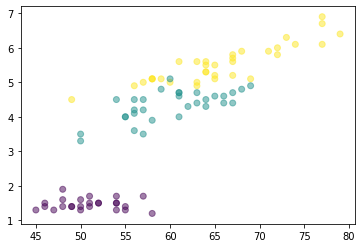

In [25]:
plt.scatter(Xtrain[:, 0], Xtrain[:, 2], c=ytrain, alpha=0.5)
plt.show()

Jak ale uvidíme za chvíli, kNN je velice citlivé na různě velké rozsahy hodnot jednotlivých příznaků.

Z trénovacích dat si ještě ukrojíme validační:

In [26]:
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.4, random_state=random_seed)

Natrénujeme kNN klasifikátor (s defaultními hyperparametry) a změříme přesnost klasifikace na validačních datech:

In [34]:
model = KNeighborsClassifier()
model.fit(Xtrain, ytrain)
print('Validation accuracy of non-normalized model %.4lf' % model.score(Xval, yval))

Validation accuracy of non-normalized model 0.7500


Přesnost bohužel není příliš vysoká.

Zkusíme proto jiný přístup. Data nejprve normalizujeme pomocí min-max normalizace. To v Pythonu uděláme pomocí třídy `MinMaxScaler` z modulu `sklearn.preprocessing`:

In [35]:
# Min-max scaler nafitujeme na trénovacích datech
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

# Následně stejnou transformaci aplikujeme i na validační data
Xval_scaled = scaler.transform(Xval)

# Natrénujeme model na transformovaných datech
model = KNeighborsClassifier()
model.fit(Xtrain_scaled, ytrain)

print('Validation accuracy of normalized model: %.4lf' % model.score(Xval_scaled, yval))

Validation accuracy of normalized model: 0.9722


Taková přesnost už je velice pěkná.

Na závěr můžeme změřit i přesnost klasifikace na testovacích datech:

In [36]:
Xtest_scaled = scaler.transform(Xtest)
print('Test accuracy of normalized model: %.4lf' % model.score(Xtest_scaled, ytest))

Test accuracy of normalized model: 0.9667


### Pár bodů k zamyšlení

- Člověka by mohlo napadnout provést normalizaci na celém trénovacím datasetu a až potom provádět validaci. V tu chvíli by ale validační chyba nebyla objektivní. (Je to podobné, jako bychom při trénování používali i testovací data.)
- Min-max normalizace není všespásná, jedná se o obyčejnou lineární transformaci. Obecně jí dělají problém odlehlé hodnoty (outlieři). V tu chvíli je vhodné buď outliery nejprve odstranit, nebo použít robustnější metodu normalizace.

## Práce s datasetem house prices

Načteme si dataset house prices.

In [37]:
data = pd.read_csv('house-prices-train.csv')
data.set_index('Id', drop=True, verify_integrity=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Predikovat budeme hodnotu sloupce `SalePrice`. Vykreslíme si proto rozdělení jeho hodnot. Letmým pohledem nám toto rozdělení může připomínat log-normální, nicméně dopodrobna se tím zabývat nebudeme.

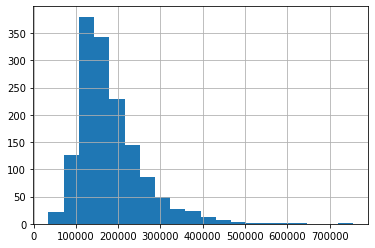

In [38]:
data.SalePrice.hist(bins=20)
plt.show()

Mírně si ulehčíme život a provedeme logaritmickou transformaci. To je samozřejmě validní operace, která v některých případech může zvýšit přesnost výsledného odhadu. Zároveň ale platí, že to nefunguje univerzálně u libovolného typu dat. V tomto konkrétním případě se prostě spokojíme s informací v podobě *deus ex machina*, že nám to pomůže.

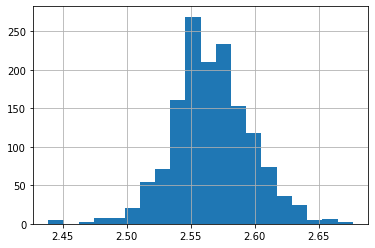

In [40]:
data.SalePrice = np.log1p(data.SalePrice)
data.SalePrice.hist(bins=20)
plt.show()

Na tuto skutečnost nesmíme zapomenout při závěrečné práci s testovacím datasetem. Na predikované hodnoty tedy musíme aplikovat inverzní funkci, v našem případě `np.expm1`.

### Čištění dat

Metodu kNN nelze použít, pokud máme v datasetu nominální příznaky. To lze vyřešit několika způsoby:
- Z datasetu nominální hodnoty úplně odstraníme (přičemž můžeme ponechat ordinální, dává-li smysl mezi nimi měřit vzdálenost).
- Použijeme one-hot enkódování a nominální příznaky nahradíme dummy příznaky.
- Použijeme nějakou [sofistikovanější metriku](https://www.researchgate.net/publication/220907006_Similarity_Measures_for_Categorical_Data_A_Comparative_Evaluation), která umí porovnávat nominální hodnoty.

Nejprve použijeme kód z předchozích cvičení pro nahrazení kategorických příznaků dummy příznaky.

In [41]:
def encode_categories(df, mappers, dummies=False):
    le = LabelEncoder()
    for col in df.select_dtypes('object').columns:
        if col not in mappers and df[col].nunique() < 30:
            df[col] = df[col].fillna('NaN')
            df[col] = le.fit_transform(df[col])
            if dummies:
                prefix = 'd_' + col
                df = pd.concat([df.drop(columns=[col]), pd.get_dummies(df[col], prefix=prefix)], axis=1)
        elif col in mappers:
            df[col] = df[col].replace(mappers[col])
    return df

In [42]:
ordinal_cols_mappers = {
    'KitchenQual': { 'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4 }
}
data = encode_categories(data, ordinal_cols_mappers, True)
print('Shape:', data.shape)

Shape: (1460, 302)


Jak již bylo řečeno, z datasetu můžeme samozřejmě tyto příznaky úplně odstranit. To bude částí vašeho úkolu. Prozatím je ovšem necháme tak, jak jsou.

In [43]:
drop_dummies = False
if drop_dummies:
    data = data.drop(columns=data.columns[data.columns.str.startswith('d_')])

### Pokus o natrénování modelu

Zkusíme nyní natrénovat model.

In [44]:
model = KNeighborsRegressor(n_neighbors=5)
try:
    model.fit(data.drop(columns=['SalePrice']), data.SalePrice)
except Exception as ex:
    print(ex)

Input contains NaN, infinity or a value too large for dtype('float64').


Vypadá to ale, že máme v datasetu nějaké chybějící hodnoty.

In [45]:
data.loc[:, data.isnull().sum() > 0].isnull().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

Co s tím?
- Můžeme tyto záznamy z datasetu úplně odstranit. Problém ovšem může nastat ve dvou případech:
    1. V trénovacím datasetu nemáme příliš mnoho záznamů a nemůžeme si tedy dovolit žádný odstranit.
    2. Hodnoty mohou chybět i v testovacím datasetu a v tu chvíli nemáme jak provést predikci.
- Můžeme odstranit příznaky, které obsahují chybějící hodnoty. I tady ale mohou vznikat problémy:
    1. Příznaků nemusí být mnoho, takže si je nemůžeme dovolit odstranit.
    2. Příznaky mohou být důležité a jejich odstraněním bychom značně degradovali kvalitu modelu.
- Chybějící hodnoty se můžeme pokusit doplnit.

### Křížová validace

<center><img src="img/cross-validation.png" width="60%"></center>

- Místo fixně dané validační množiny používáme v každé iteraci různé části trénovací množiny.
- Validační chybu průměrujeme přes všechny iterace.
- Typicky používáme:
    - `KFold`, kde se data rozdělí na `k` stejně velkých částí. Jedna část se použije jako validační množina a zbytek jako trénovací.
    - `LeaveOneOut`, kde se jako validační množina použije jeden jediný prvek. V zásadě se jedná o speciální případ `KFold`, kde `k = n`.

Stejně jako v minulých cvičeních si definujeme rozsahy hyperparemetrů, které budeme zkoumat.

In [46]:
# Hodnoty hyperparametrů
param_grid = {
    'n_neighbors' : range(1, 12), # Počet nejbližších sousedů
    'p': range(1, 3), # Stupeň Minkowského vzdálenosti
    'weights': ['uniform', 'distance'], # Aritmetický, nebo vážený průměr
}
param_comb = ParameterGrid(param_grid)

# Počet foldů (k) křížové validace
n_splits = 5

# Sloupce
missing_cols = data.loc[:, data.isnull().sum() > 0].isnull().columns.to_list()
target_col = 'SalePrice'
drop_cols = missing_cols + [target_col]

Zkusíme nyní křížovou validaci použít při natrénování modelu. Prozatím odstraníme příznaky s chybějícími hodnotami.

In [47]:
err = []
for params in param_comb:
    print('Combination', len(err) + 1, '/', len(param_comb))
    
    comb_err = []
    # Pomocí KFold rozdělíme index na trénovací a validační
    for train, val in KFold(n_splits=n_splits, random_state=random_seed).split(data.index):
        print('Fold', len(comb_err) + 1, '/', n_splits)
        
        # Z trénovacích i validačních dat odstraníme sloupce s chybějícími hodnotami
        Xtrain = data[data.index.isin(train)].drop(columns=drop_cols)
        ytrain = data[data.index.isin(train)][target_col]
        Xval = data[data.index.isin(val)].drop(columns=drop_cols)
        yval = data[data.index.isin(val)][target_col]
        
        # Scaler opět nafitujeme podle trénovacích dat a následně transformujeme i validační
        scaler = MinMaxScaler()
        Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
        Xval = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)
        
        # Natrénujeme model a změříme validační chybu (RMSLE)
        model = KNeighborsRegressor(**params)
        model.fit(Xtrain, ytrain)
        comb_err.append(np.sqrt(metrics.mean_squared_error(yval, model.predict(Xval))))
    
    # Zprůměrujeme chybu
    err.append(np.mean(comb_err))

Combination 1 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 2 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 3 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 4 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 5 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 6 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 7 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 8 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 9 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 10 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 11 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 12 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 13 / 44
Fold 1 / 5
Fold 2 / 5
Fold 3 / 5
Fold 4 / 5
Fold 5 / 5
Combination 14 / 44
Fold 1 / 5
Fol

In [48]:
# Vypíšeme parametry a chybu nejlepšího modelu
best_index = np.argmin(err)
best_params = param_comb[best_index]
best_err = err[best_index]
print('Best params:', best_params)
print('Best RMSLE: ', best_err)

Best params: {'weights': 'distance', 'p': 1, 'n_neighbors': 11}
Best RMSLE:  0.01481601678673187


Průměrná validační chyba nejlepšího modelu není úplně špatná. Na [Kagglu](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard) ale můžeme vidět, že to jde i znatelně lépe. (Tam už je samozřejmě testovací chyba, ale jistou představu nám to dává.) Začneme tím, že se pokusíme doplnit chybějící hodnoty.

*Poznámka: Balíček `sklearn` obsahuje řadu dalších funkcí pro křížovou validaci:*
  * [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
  * [cross_validate](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
  * [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### Doplnění chybějících hodnot

V zásadě existuje mnoho způsobů, jak toho docílit. My si ukážeme dva základní:
- Můžeme jednoduše chybějící hodnoty nahradit průměrem příslušného příznaku. Ačkoli to může fungovat, jedná se obecně o poslední možnost, po které bychom měli sáhnout.
- Chybějící hodnoty můžeme nahradit hodnotami z nejpodobnějších záznamů. Použijeme tedy metodu kNN!

Jak to udělat?
- Data rozdělíme na dvě části podle toho, zda v nich chybí hodnoty, nebo nikoli.
- Následně natrénujeme model na kompletních hodnotách, přičemž jako predikovanou proměnnou použijeme příznak, který v druhé množině chybí. V našem případě se jedná o příznaky `LotFrontage`, `MasVnrArea` a `GarageYrBlt`.
- Hodnoty v druhé množině nyní jednoduše doplníme pomocí predikce.

In [ ]:
imputation_err = {}
for col in missing_cols:
    print('Column', col)
    
    # Vezme si pouze kompletní data a odstraníme z nich originální odhadovanou proměnnou (SalePrice)
    data_notnull = data.dropna().drop(columns=target_col)
    
    mean_imp_err = []
    knn_imp_err = []
    for train, val in KFold(n_splits=n_splits, random_state=random_seed).split(data_notnull.index):
        print('Fold', len(mean_imp_err) + 1, '/', n_splits)
        
        # Z dat odstraníme příznaky, ve kterých byly chybějící hodnoty
        Xtrain = data_notnull[data_notnull.index.isin(train)].drop(columns=missing_cols)
        # Odhaujeme vždy jeden z chybějících sloupců
        ytrain = data_notnull[data_notnull.index.isin(train)][col]
        Xval = data_notnull[data_notnull.index.isin(val)].drop(columns=missing_cols)
        yval = data_notnull[data_notnull.index.isin(val)][col]
        
        # Scaler opět nafitujeme podle trénovacích dat a následně transformujeme i validační
        scaler = MinMaxScaler()
        Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
        Xval = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)
        
        # Změříme RMSLE pro doplnění průměrem
        mean_imp_err.append(np.sqrt(metrics.mean_squared_log_error(yval, np.ones(len(yval)) * ytrain.mean())))
        
        # Natrénujeme model pro odhad chybějícího sloupce
        model = KNeighborsRegressor(n_neighbors=5, weights='distance')
        model.fit(Xtrain, ytrain)
        # Změříme RMSLE pro doplnění pomocí kNN
        knn_imp_err.append(np.sqrt(metrics.mean_squared_log_error(yval, model.predict(Xval))))
    
    # Zprůměrujeme chybu
    imputation_err[col] = {
        'mean': np.mean(mean_imp_err),
        'knn': np.mean(knn_imp_err),
    }

In [ ]:
# Vypíšeme chybu odhadu pro jednotlivé sloupce
for col, err in imputation_err.items():
    print('Column', col)
    print('Mean imputation RMSLE:', err['mean'])
    print('kNN imputation RMSLE: ', err['knn'])
    print('')

Z výsledků jasně vidíme, že doplňování hodnot pomocí kNN je mnohem přesnější než obyčejné nahrazení průměrem.

*Poznámka: Správně bychom měli ještě ladit hyperparametry i pro doplňovací model. To si zkuste v rámci úkolu.*

### Trénování modelu s doplněním hodnot pomocí `KNNImputer`

Doplňování si ale (ostatně jako řadu jiných věcí) nemusíme psát sami. V modulu `sklearn.impute` najdeme hotovou třídu `KNNImputer`.

In [ ]:
err = []
for params in param_comb:
    print('Combination', len(err) + 1, '/', len(param_comb))
    
    comb_err = []
    for train, val in KFold(n_splits=n_splits, random_state=random_seed).split(data.index):
        print('Fold', len(comb_err) + 1, '/', n_splits)
        
        # Používáme všechna data
        Xtrain = data[data.index.isin(train)].drop(columns=target_col)
        ytrain = data[data.index.isin(train)][target_col]
        Xval = data[data.index.isin(val)].drop(columns=target_col)
        yval = data[data.index.isin(val)][target_col]
        
        # Scaler opět nafitujeme podle trénovacích dat a následně transformujeme i validační
        scaler = MinMaxScaler()
        Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
        Xval = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)
        
        # KNNImputer nafitujeme na trénovacích datech a následně provedeme doplnění ve validačních datech
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        Xtrain = pd.DataFrame(imputer.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
        Xval = pd.DataFrame(imputer.transform(Xval), index=Xval.index, columns=Xval.columns)
        
        # Natrénujeme model a změříme validační chybu (RMSLE)
        model = KNeighborsRegressor(**params)
        model.fit(Xtrain, ytrain)
        comb_err.append(np.sqrt(metrics.mean_squared_error(yval, model.predict(Xval))))
    
    # Zprůměrujeme chybu
    err.append(np.mean(comb_err))

In [ ]:
# Vypíšeme parametry a chybu nejlepšího modelu
best_index = np.argmin(err)
best_params = param_comb[best_index]
best_err = err[best_index]
print('Best params:', best_params)
print('Best RMSLE: ', best_err)

Vidíme, že validační chyba je (dle očekávání) opět o něco menší.

## Prokletí dimenzionality

- Normalizovaná data jsou rozprostřena v $n$-rozměrné krychli o délce strany 1.
- Diagonála této krychle (za použití euklidovské vzdálenosti) měrí $\sqrt{n}$. To je zároveň nejvyšší možná vzdálenost, jakou mezi sebou dva body mohou mít.
- Prokletí dimenzionality znamená, že se zvyšující se dimenzí se vzdálenost k nejbližšímu sousedovi zvyšuje.
- Tento efekt můžeme poměrně dobře demonstrovat. Pro různé počty příznaků napočítáme poměr průměrné vzdálenosti k nejbližšímu sousedovi oproti diagonále krychle. (Dostáváme tedy vzdálenost relativní vůči maximální možné.) To samé můžeme spočítat i pro nejvzdálenější sousedy a pro průměr všech sousedů.

In [ ]:
# Data pro jednoduchost rozdělíme na trénovací a validační a odstraníme z nich příznaky s chybějícími hodnotami
train, val = train_test_split(data.index, test_size=0.4, random_state=random_seed)
Xtrain = data[data.index.isin(train)].drop(columns=drop_cols)
ytrain = data[data.index.isin(train)][target_col]
Xval = data[data.index.isin(val)].drop(columns=drop_cols)
yval = data[data.index.isin(val)][target_col]

# Scaler opět nafitujeme podle trénovacích dat a následně transformujeme i validační
scaler = MinMaxScaler()
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
Xval = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)

min_dist_ratio = []
max_dist_ratio = []
mean_dist_ratio = []
for n in range(1, 80 + 1):
    # Natrénujeme model pro různé počty příznaků
    model = KNeighborsRegressor(n_neighbors=10, p=2)
    model.fit(Xtrain.iloc[:, 0:n], ytrain)
    # Změříme vzdálenost pro všechny body z validační množiny
    dist, nn = model.kneighbors(Xval.iloc[:, 0:n])
    # Spočítáme průměrné vzdálenosti
    min_dist_ratio.append(np.mean(np.min(dist, axis=1)) / math.sqrt(n))
    max_dist_ratio.append(np.mean(np.max(dist, axis=1)) / math.sqrt(n))
    mean_dist_ratio.append(np.mean(np.mean(dist, axis=1)) / math.sqrt(n))

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('dimensions')
plt.plot(range(1, len(min_dist_ratio) + 1), min_dist_ratio, 'go-', alpha=0.25, label='Avg. distance to nearest neighbor')
plt.plot(range(1, len(mean_dist_ratio) + 1), mean_dist_ratio, 'bo-', label='Avg. distance to mean of all neighbors')
plt.plot(range(1, len(max_dist_ratio) + 1), max_dist_ratio, 'ro-', alpha=0.25, label='Avg. distance to farthest neighbor')
plt.legend()
plt.show()

*K zamyšlení: Proč křivka občas klesá? (Zkuste místo relativní vzdálenosti použít absolutní.)*

**Úkol:** Zkuste experimentovat s hyperparametrem `n_neighbors`. Jaký má jeho hodnota vliv na průměrnou vzdálenost? Vykreslete do jednoho grafu křivky pro více hodnot hyperparametru a porovnejte je.

## Úkol

- Hrajte si s modelem a pokuste se dosáhnout co nejmenší validační chyby. (Použijte křížovou validaci.)
- Zkusit můžete:
    - Změnit prohledávatelný rozsah hyperparametrů.
    - Úplně odstranit nominální příznaky.
    - Použít jinou podmnožinu příznaků.
    - Ladit hyperparametry doplňovacího modelu (`KNNImputer`).
    - Nepoužívat normalizaci (případně používat jinou).
    - Cokoli dalšího vás napadne.
- Výsledný model spusťte na testovacích datech (`house-prices-test.csv`) a své predikce (ve formě CSV) nahrajte na [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit). CSV musí obsahovat sloupce `Id` a `SalePrice`. (Nezapomeňte na použití inverzní funkce.)

In [ ]:
# Odtud je to vaše.
